### Installation and Setup

First, we need to intall the package

In [1]:
] add PyCall

  Updating registry at `~/.julia/registries/General`
  Updating git-repo `https://github.com/JuliaRegistries/General.git`
 Resolving package versions...
  Updating `~/.julia/environments/v1.0/Project.toml`
 [no changes]
  Updating `~/.julia/environments/v1.0/Manifest.toml`
 [no changes]


In [2]:
] add Conda

 Resolving package versions...
  Updating `~/.julia/environments/v1.0/Project.toml`
 [no changes]
  Updating `~/.julia/environments/v1.0/Manifest.toml`
 [no changes]


This installs a Conda installation in the user depot, which we can see as follows

In [3]:
using PyCall, Conda 
@show Conda.PYTHONDIR # this is also Conda.ROOTENV

Conda.PYTHONDIR = "/Users/arnavsood/.julia/conda/3/bin"


"/Users/arnavsood/.julia/conda/3/bin"

Next, we need to install the actual solver package

In [4]:
Conda.add("pip") # Adds the pip installer to Julia's Python
run(`$(PyCall.pyprogramname) -m pip install --pre dfogn`) # add dfogn to ...

┌ Info: Running `conda install -y pip` in root environment
└ @ Conda /Users/arnavsood/.julia/packages/Conda/uQitS/src/Conda.jl:112


Solving environment: ...working... done

# All requested packages already installed.



Process(`/Users/arnavsood/.julia/conda/3/bin/python -m pip install --pre dfogn`, ProcessExited(0))

We can see the package from Julia now

In [5]:
@pyimport dfogn

### Toy Example

Here's a simple, vanilla example

In [6]:
# Rosenbrock
rosenbrock(x) = [10. *(x[2]-x[1])^2, 1. - x[1]]
x0 = [-1.2, 1.]
soln = dfogn.solve(rosenbrock, x0)

PyObject <dfogn.dfogn.OptimResults object at 0x12a8301d0>

In [7]:
# Unpack the results
@show soln[:x] # optimum
@show soln[:resid] # residual at optimum
@show soln[:f] # value of objective at optimum 
@show soln[:msg] # halting reason 
@show soln[:jacobian] # empirical jacobian 

# etc. 

# The key is to unpack with symbols soln[:fieldname] as opposed to soln.fieldname

soln[:x] = [1.0, 1.0002]
soln[:resid] = [3.98096e-7, 0.0]
soln[:f] = 1.5848034648780586e-13
soln[:msg] = "Success: Objective is sufficiently small"
soln[:jacobian] = [-0.00836832 0.00836814; -1.0 -4.86754e-14]


2×2 Array{Float64,2}:
 -0.00836832   0.00836814 
 -1.0         -4.86754e-14

### PTW Dynamics

First, define our helper functions, structs, etc. (eventually these will be upstreamed into QuantEcon/DFOGN.jl)

In [8]:
# Key objects
struct DFOGNResults{TI <: Integer, TF <: AbstractFloat}
    x::Array{TF, 1}
    resid::Array{TF, 1}
    f::TF
    jacobian::Matrix{TF}
    nf::TI
    flag::TI
    msg::String
end

function solve(objfun, x0;
                lower = fill(-10e20, size(x0)), # vector of lower bounds (DFOGN defaults)
                upper = fill(10e20, size(x0)), # vector of upper bounds
                maxfun = 1000, # max # of function calls
                rhoend = 1e-8) # minimum allowed ρ

    soln = dfogn.solve(objfun, x0, lower = lower, upper = upper, maxfun = maxfun, rhoend = rhoend)
    soln[:flag] == 0 || error(soln[:msg])
    return DFOGNResults(soln[:x], soln[:resid], soln[:f], soln[:jacobian], soln[:nf], soln[:flag], soln[:msg])
end

# Helper functions
converged(d::DFOGNResults) = (d.flag == 0)
optimizer(d::DFOGNResults) = d.x
optimum(d::DFOGNResults) = d.f
residuals(d::DFOGNResults) = d.resid
jacobian(d::DFOGNResults) = d.jacobian
numcalls(d::DFOGNResults) = d.nf
flag(d::DFOGNResults) = d.flag
msg(d::DFOGNResults) = d.msg

msg (generic function with 1 method)

Load PTW and other Julia dependencies

In [9]:
using PerlaTonettiWaugh
using LinearAlgebra, Parameters, Interpolations, Statistics, Compat

Write a modified simple dynamics problem to give to the solver

In [56]:
x = t -> 14.5
θ = 0.1
ξ = 1.0

1.0

In [57]:
z_min = 0.0
z_max = 5.0
M = 100
z_grid = range(z_min, z_max, length = M) 

0.0:0.050505050505050504:5.0

In [58]:
ω = ω_weights(z_grid, θ, ξ)

100-element Array{Float64,1}:
 0.006417914349840399
 0.013432738827788861
 0.014057407327356565
 0.014711125058012186
 0.01539524290879109 
 0.016111174589709343
 0.01686039955315513 
 0.017644466051134903
 0.018464994334691943
 0.01932368000210895 
 0.020222297502813437
 0.0211627038042269  
 0.022146842229135   
 ⋮                   
 0.7008125011449126  
 0.7334026898756603  
 0.7675084343360362  
 0.8032002130736917  
 0.8405517821308772  
 0.8796403274591338  
 0.9205466244219158  
 0.9633552047145856  
 1.008154531046671   
 1.0550371799476153  
 1.1041000330734885  
 0.5777222387050824  

In [59]:
# takes a value function guess at a time point t 
f = v -> [v[1] + x(v[end]) - dot(ω, v[1:end-1])]

#32 (generic function with 1 method)

In [60]:
# solve with NLLS
T = 10. 
valuefunctions = []
x0 = fill(1., size(z_grid));

In [61]:
for t in 0:0.1:T
    sol = solve(f, [x0; t])
    converged(sol) || throw(msg(sol))
    push!(valuefunctions, optimizer(sol)[1:end-1])
end

In [63]:
sol = solve(f, [x0; 10.])

DFOGNResults{Int64,Float64}([2.55988, 0.992431, 0.992079, 0.99171, 0.991325, 0.990921, 0.990499, 0.990057, 0.989595, 0.989111  …  0.547398, 0.526351, 0.504324, 0.481274, 0.457151, 0.431907, 0.405488, 0.377842, 0.674455, 10.0], [1.42109e-14], 2.0194839173657902e-28, [0.993582 -0.0134327 … -0.577722 2.00755e-15], 104, 0, "Success: Objective is sufficiently small")

In [64]:
optimum(sol)

2.0194839173657902e-28

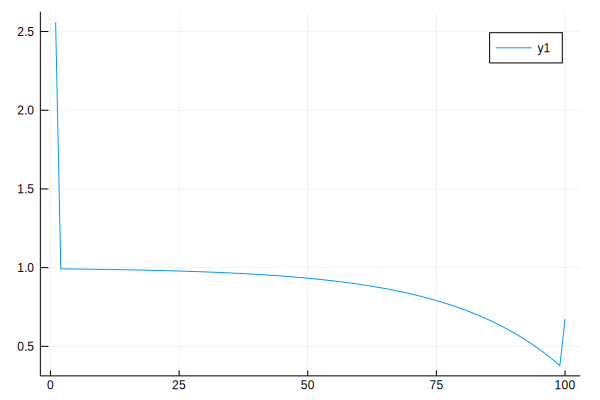

In [69]:
plot(sol.x[1:end-1])